In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

from ffflows.models import BaseFlow
from ffflows.utils import set_trainable
from ffflows.utils import get_activation, spline_inn, get_flow4flow, get_conditional_data

from nflows.distributions import StandardNormal

from ffflows.data.conditional_plane import ScienceDataset

import yaml


device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

dpi = 100

cuda:2


In [2]:
eval_results_dir = "/global/ml4hep/spss/rrmastandrea/flows4flows/writeup2/"


labels_dir = {"baseline":"Baseline",
              "left":"Reference",
              "right":"Target",
              "base_transfer":"Base Transfer",
              "f4f":"Flows for Flows",
              "unidir_end":"Unidirectional transfer",
              "L1_start":"Movement Penalty",
              "L1_end":"Movement Penalty",
              "II_start":"Identity Initialization",
              "II_end":"Identity Initialization",}

# Nonconditional data

Helper functions

In [3]:
def collect_all_data_nocond(key):
    
    print(f"Working on key {key}...")
    
    transported_results = {}
    
    eval_dict_root = f"{eval_results_dir}/{key}_f4f/"
    results_root = pd.read_hdf(f"{eval_dict_root}/eval_data.h5")
    
    transported_results["left"] = [results_root["left_data_x"], results_root["left_data_y"]]
    transported_results["right"] = [results_root["right_data_x"], results_root["right_data_y"]]

    transported_results["base_transfer"] = [results_root["base_transfer_x"], results_root["base_transfer_y"]]
    transported_results["f4f"] = [results_root["left_to_right_x"], results_root["left_to_right_y"]]
    
    # unidir
    eval_dict_unidir = f"{eval_results_dir}/{key}_inv/"
    results_unidir = pd.read_hdf(f"{eval_dict_unidir}/eval_data.h5")
    transported_results["unidir_start"] = [results_unidir["left_data_x"], results_unidir["left_data_y"]]
    transported_results["unidir_end"] = [results_unidir["left_to_right_x"], results_unidir["left_to_right_y"]]

    # L1
    eval_dict_l1 = f"{eval_results_dir}/{key}_L1/"
    results_l1 = pd.read_hdf(f"{eval_dict_l1}/eval_data.h5")
    transported_results["L1_start"] = [results_l1["left_data_x"], results_l1["left_data_y"]]
    transported_results["L1_end"] = [results_l1["left_to_right_x"], results_l1["left_to_right_y"]]
    
    # II
    #eval_dict_identinit = f"{eval_results_dir}/{key}_identinit/"
    #results_identinit = pd.read_hdf(f"{eval_dict_identinit}/eval_data.h5")
    eval_dict_identinit = "/global/home/users/rrmastandrea/flows4flows/new_ident_init/f4f_nocond"
    left_dist = key.split("_")[0]
    right_dist = key.split("_")[1]
    loc_dir = f"new_id_init_basedistleftdata_{left_dist}_basedistrightdata_{right_dist}_toptransformerdirection_alternate_toptransformerpenalty_None_toptransformerpenaltyweight_1_toptransformeridentityinit_True"
    results_identinit = pd.read_hdf(f"{eval_dict_identinit}/{loc_dir}/eval_data.h5") 
    transported_results["II_start"] = [results_identinit["left_data_x"], results_identinit["left_data_y"]]
    transported_results["II_end"] = [results_identinit["left_to_right_x"], results_identinit["left_to_right_y"]]
   
    return transported_results



In [4]:


# get the data

combos_identity = ["star_star", "fourcircles_fourcircles", "checkerboard_checkerboard"]
results_identity = {}

combos_transfer = ["star_fourcircles", "fourcircles_star", "fourcircles_checkerboard", "checkerboard_fourcircles",
                   "checkerboard_star", "star_checkerboard"]
results_transfer = {}

for c in combos_identity:
    results_identity[c] = collect_all_data_nocond(f"{c}_nocond")
    
for c in combos_transfer:
    results_transfer[c] = collect_all_data_nocond(f"{c}_nocond")
    



Working on key star_star_nocond...
Working on key fourcircles_fourcircles_nocond...
Working on key checkerboard_checkerboard_nocond...
Working on key star_fourcircles_nocond...
Working on key fourcircles_star_nocond...
Working on key fourcircles_checkerboard_nocond...
Working on key checkerboard_fourcircles_nocond...
Working on key checkerboard_star_nocond...
Working on key star_checkerboard_nocond...


Plot each method (base, target, transfer color-coded)

In [5]:
# plotting params

f_1 = 20
f_2 = 16
f_3 = 14

import matplotlib.cm as cm

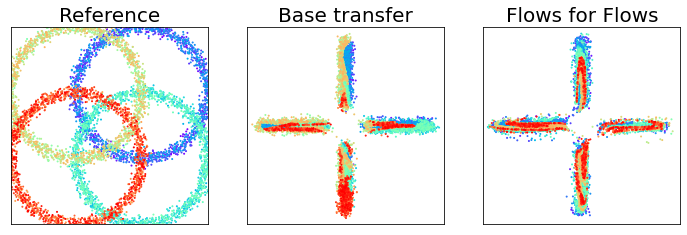

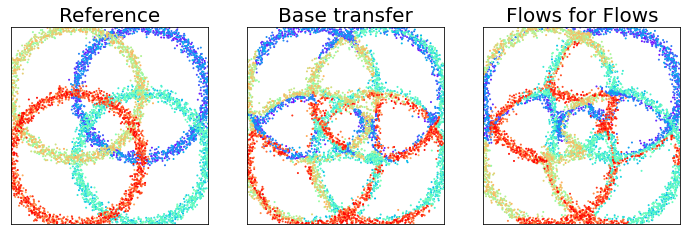

In [6]:



def plot_color_coded_transfer(all_results_dir, combo, base_key, target_key_1, target_key_2, size = 6, b = np.linspace(-3, 3, 100), 
                              cmap = cm.rainbow, n_points = 7000, s = 1):
    
    fig, ax = plt.subplots(1, 3, figsize = (2*size, size))
    
    # we only want to plot every n_th point
    num_total_points = len(all_results_dir[combo][base_key][0])
    n_skip = int(num_total_points/n_points)
    colors = [cmap(x) for x in np.linspace(0, 1, n_points)]

    
    # input
    ax[0].scatter(all_results_dir[combo][base_key][0][:n_skip*n_points:n_skip], all_results_dir[combo][base_key][1][:n_skip*n_points:n_skip], color=colors, s = s, rasterized = True)
    ax[0].set_title("Reference", fontsize = f_1)
    
    # target 1
    ax[1].scatter(all_results_dir[combo][target_key_1][0][:n_skip*n_points:n_skip], all_results_dir[combo][target_key_1][1][:n_skip*n_points:n_skip], color=colors, s = s, rasterized = True)
    ax[1].set_title("Base transfer", fontsize = f_1)

    ax[2].scatter(all_results_dir[combo][target_key_2][0][:n_skip*n_points:n_skip], all_results_dir[combo][target_key_2][1][:n_skip*n_points:n_skip], color=colors, s = s, rasterized = True)
    ax[2].set_title("Flows for Flows", fontsize = f_1)

    
    
    # axis settings
    for i in range(3):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_xlim([-3, 3])
        ax[i].set_ylim([-3, 3])
        ax[i].set_aspect("equal")

    #plt.subplots_adjust(wspace=0, hspace=0)
    fig.show()
    plt.savefig(f"plots/{combo}_{target_key_1}_{target_key_2}.pdf", bbox_inches="tight", dpi = dpi)
    
plot_color_coded_transfer(results_transfer, "fourcircles_star", "left", "base_transfer", "f4f")

plot_color_coded_transfer(results_identity, "fourcircles_fourcircles", "left", "base_transfer", "f4f")


Plot all methods

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this w

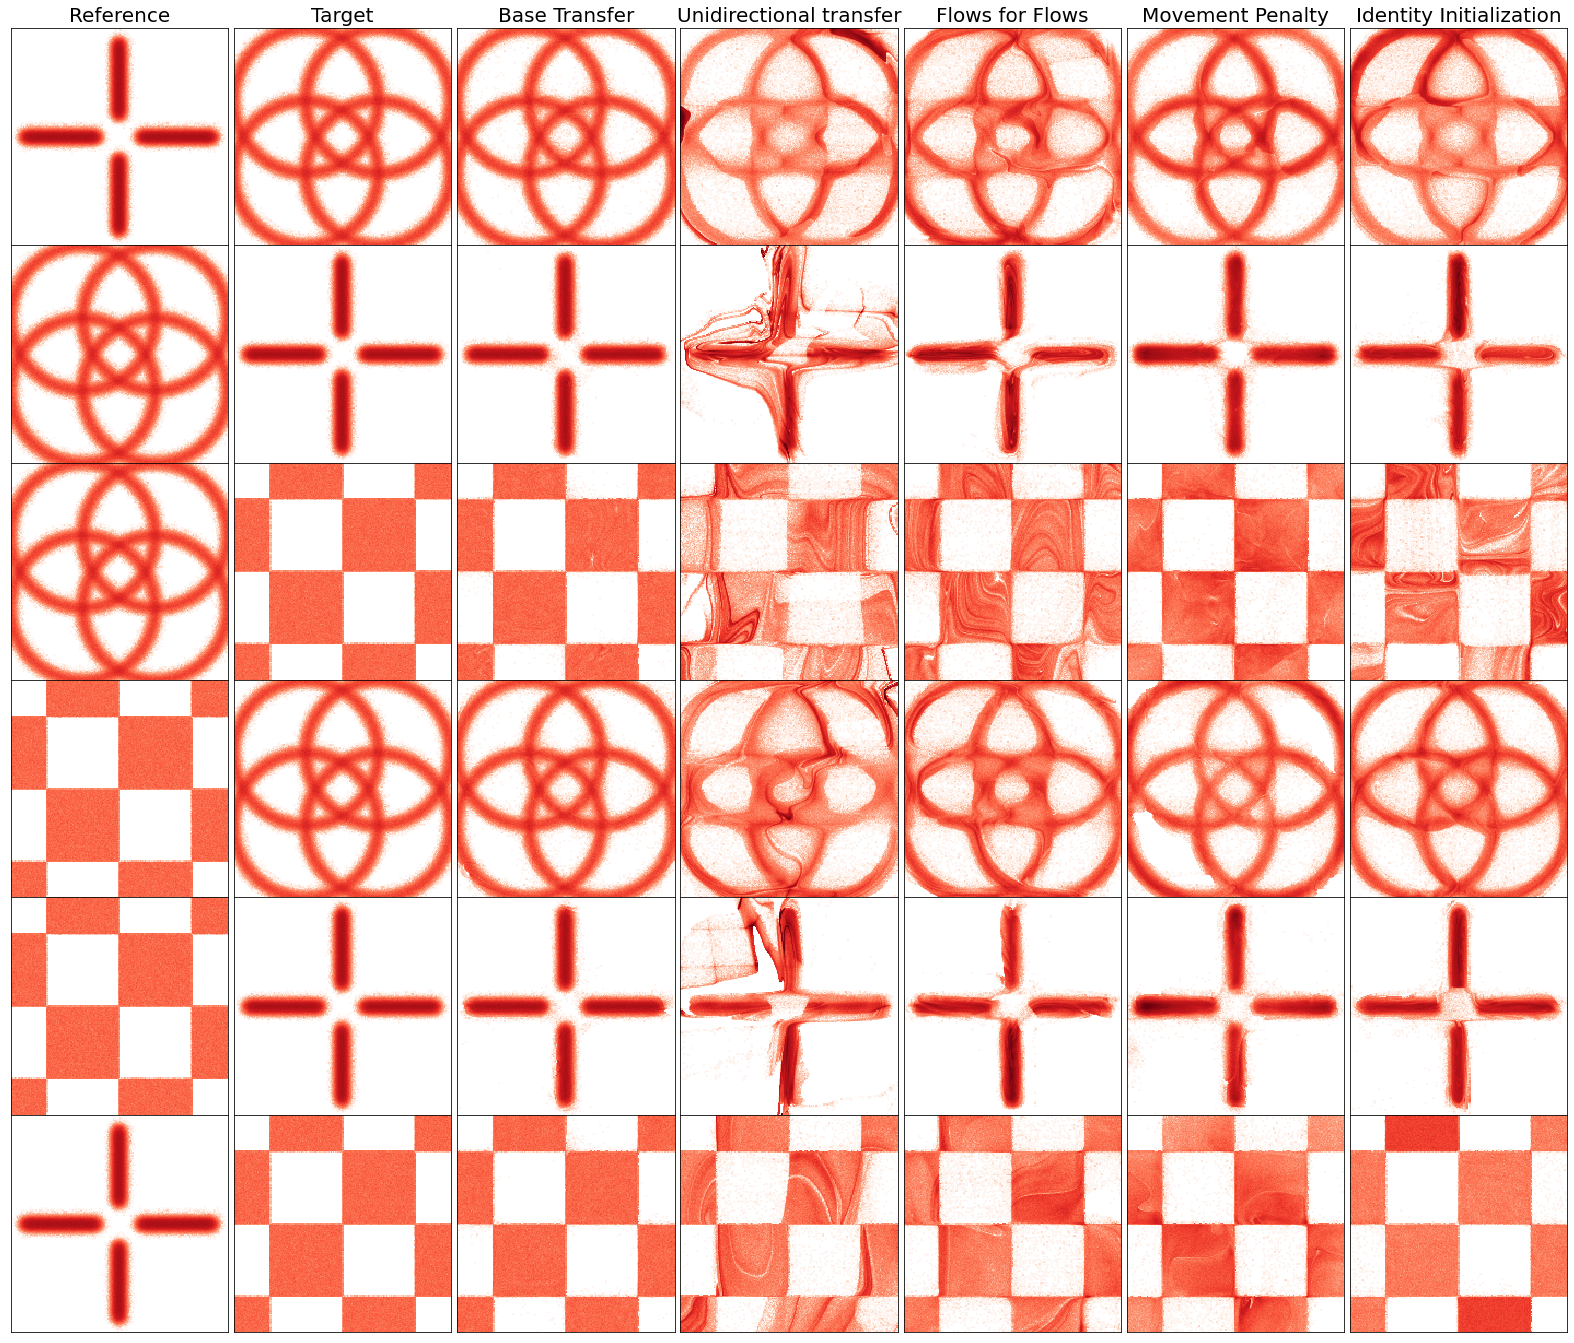

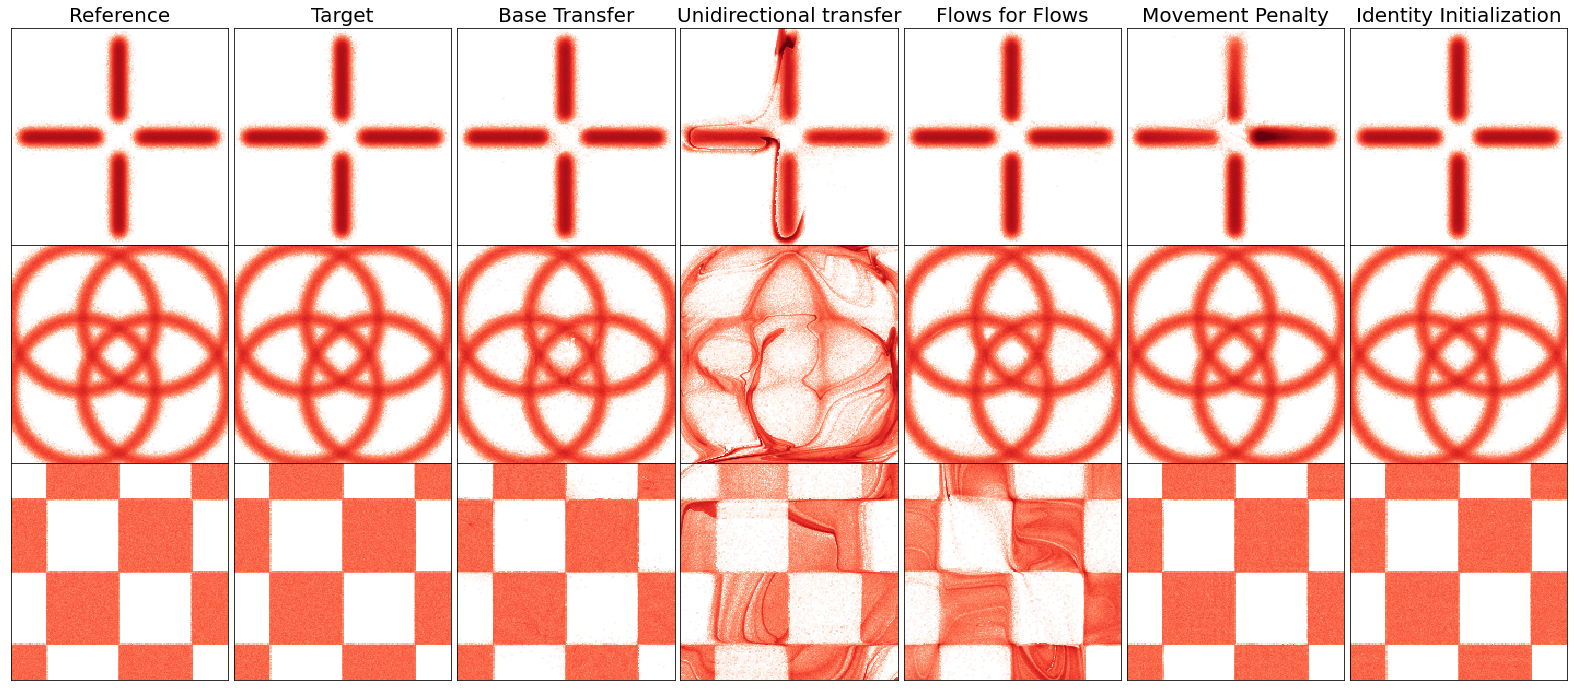

In [7]:
from matplotlib.colors import LogNorm



def plot_all_methods(keys_to_plot, combos_to_plot, all_results_dict, keyword, size = 4, b = 200, 
                              cmap = cm.Reds, l = 3):
    
    cmap.set_under("white")

    num_plots = len(keys_to_plot)
    num_combos = len(combos_to_plot)
    
    fig, ax = plt.subplots(num_combos, num_plots, figsize = (num_plots*size, num_combos*size))

    for j, combo in enumerate(combos_to_plot):
        
        for i, key in enumerate(keys_to_plot):
                        
            lll = ax[j,i].hist2d(all_results_dict[combo][key][0], all_results_dict[combo][key][1], 
                           bins = np.linspace(-l, l, b), cmap = cmap, vmax = 1.4, norm=LogNorm(),
                                 density = True, rasterized = True)
            
            if j == 0:
                ax[j,i].set_title(labels_dir[key], fontsize = f_1)

            # axis settings
            ax[j,i].set_xticks([])
            ax[j,i].set_yticks([])
            ax[j,i].set_xlim([-l, l])
            ax[j,i].set_ylim([-l, l])
            ax[j,i].set_aspect("equal")

    plt.subplots_adjust(wspace=0, hspace=0)
    fig.show()
    plt.savefig(f"plots/summary_{keyword}.pdf", bbox_inches="tight", dpi = dpi)


keys_to_plot = ["left", "right", "base_transfer", "unidir_end", "f4f", "L1_end", "II_end"]

plot_all_methods(keys_to_plot, combos_transfer, results_transfer, "transfer")
plot_all_methods(keys_to_plot, combos_identity, results_identity,"identity")


In [ ]:

    
def calculate_distance_xy(results_dir, key_1, key_2):
    # x distance
    del_xes = results_dir[key_1][0] - results_dir[key_2][0]
    # y distance
    del_yes = results_dir[key_1][1] - results_dir[key_2][1]
    
    dists = np.sqrt(del_xes**2 + del_yes**2)
    return dists


style_dict = {"baseline":["step", "black", 1, "", 3],  # step, color, alpha, hash, linewidth
             "base_transfer":["step", "#0C5DA5", 1, "", 3],
             "f4f":["stepfilled", "#00B945", .5, "", 3],
             "unidir_end":["step", "#FF9500", 1, "", 3],
             "L1_end":["step", "#FF2C00", 1, "", 3],
             "II_end":["step", "#845B97", 1, "//", 3]}

import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 2  # previous pdf hatch linewidth


def calculate_distance_and_plot(all_results_dict, combos_to_plot, keyword, bins = 20, n_round = 2):
    
    
    distances_dict = {}
    
    
    # baseline
    dists = np.array([])
    for combo in combos_to_plot:
        loc_dists = calculate_distance_xy(all_results_dict[combo], "left", "right")
        dists = np.concatenate([dists, loc_dists])
    distances_dict["baseline"] = dists
    
    # base_transfer
    dists = np.array([])
    for combo in combos_to_plot:
        loc_dists = calculate_distance_xy(all_results_dict[combo], "left", "base_transfer")
        dists = np.concatenate([dists, loc_dists])
    distances_dict["base_transfer"] = dists
    
    # f4f
    dists = np.array([])
    for combo in combos_to_plot:
        loc_dists = calculate_distance_xy(all_results_dict[combo], "left", "f4f")
        dists = np.concatenate([dists, loc_dists])
    distances_dict["f4f"] = dists
    
    # unidir
    dists = np.array([])
    for combo in combos_to_plot:
        loc_dists = calculate_distance_xy(all_results_dict[combo], "unidir_start", "unidir_end")
        dists = np.concatenate([dists, loc_dists])
    distances_dict["unidir_end"] = dists
    
    # L1
    dists = np.array([])
    for combo in combos_to_plot:
        loc_dists = calculate_distance_xy(all_results_dict[combo], "L1_start", "L1_end")
        dists = np.concatenate([dists, loc_dists])
    distances_dict["L1_end"] = dists
    
    # II
    dists = np.array([])
    for combo in combos_to_plot:
        loc_dists = calculate_distance_xy(all_results_dict[combo], "II_start", "II_end")
        dists = np.concatenate([dists, loc_dists])
    distances_dict["II_end"] = dists

    fig = plt.figure(figsize = (8, 8))
    for i, key in enumerate(distances_dict.keys()):
        label = labels_dir[key]
        loc_mean = np.round(np.mean(distances_dict[key]), n_round)
        loc_std = np.round(np.std(distances_dict[key]), n_round)
        
        stats = f" ($\mu$ = {loc_mean}, $\sigma$ = {loc_std})"
        
        
        
        plt.hist(distances_dict[key], bins = bins, label = label+stats, density = True,
                            histtype = style_dict[key][0], color = style_dict[key][1],
                             alpha = style_dict[key][2], hatch = style_dict[key][3],
                 linewidth = style_dict[key][4])
        
        
        print(f"{label} & {loc_mean} & {loc_std} \\\\")
    plt.legend(fontsize = f_2-1.1, frameon = False)
    plt.tick_params(axis='both', labelsize=f_3)
    plt.xlim(-.4,8.5)
    plt.ylim(0,.6)
    plt.xlabel("Distance traveled", fontsize = f_1)
    plt.ylabel("Normalised Entries", fontsize = f_1)

    plt.savefig(f"plots/distances_traveled_{keyword}.pdf", bbox_inches="tight")
    plt.show()
    
    

    

In [ ]:
# calculate distances

#calculate_distance_and_plot(results_transfer, combos_transfer, "transfer", bins = np.linspace(0, 10, 60))

calculate_distance_and_plot(results_identity, combos_identity, "identity", bins = np.linspace(0, 10, 60))

# ncond = 1

In [11]:
import h5py

#loc = f"{eval_results_dir}/star_star_rotation_f4f/flow4flow_plots/eval_data_conditional.h5"

#loc = "/global/home/users/rrmastandrea/flows4flows/new_ident_init/f4f_idinit_cond_toys_copy/new_id_init_generalcondition_rotation_basedistleftdata_star_basedistrightdata_checkerboard_toptransformerdirection_alternate_toptransformerpenalty_None_toptransformerpenaltyweight_1/flow4flow_plots/eval_data_conditional.h5"

#h5_data = h5py.File(loc, 'r')
#print(h5_data.keys())

codes = ["7_50", "15_00", "22_50", "30_00", "37_50", "45_00"]

In [22]:
def collect_all_data_yescond(key, codes):
    
    
    transported_results = {c:{"left":[0,0], # x, y
                           "base_transfer":[0,0],
                           "f4f":[0,0],
                           "unidir_start":[0,0],
                           "unidir_end":[0,0],
                           "L1_start":[0,0],
                           "L1_end":[0,0],
                                } for c in codes}
    
    
    eval_dict_root = f"{eval_results_dir}/{key}_f4f/"
    
    for c in codes:
        results_root = pd.read_hdf(f"{eval_dict_root}/flow4flow_plots/eval_data_conditional.h5", f"f4f_{c}")
        transported_results[c]["left"] = [results_root["input_x"], results_root["input_y"]]
        transported_results[c]["base_transfer"] = [results_root["base_transfer_x"], results_root["base_transfer_y"]]
        transported_results[c]["f4f"] = [results_root["transformed_x"], results_root["transformed_y"]]
    
    # unidir
    eval_dict_unidir = f"{eval_results_dir}/{key}_inv/"
    for c in codes:
        results_unidir = pd.read_hdf(f"{eval_dict_unidir}/flow4flow_plots/eval_data_conditional.h5", f"f4f_{c}")
        transported_results[c]["unidir_start"] = [results_unidir["input_x"], results_unidir["input_y"]]
        transported_results[c]["unidir_end"] = [results_unidir["transformed_x"], results_unidir["transformed_y"]]

    # L1
    eval_dict_l1 = f"{eval_results_dir}/{key}_L1/"
    for c in codes:
        results_l1 = pd.read_hdf(f"{eval_dict_l1}/flow4flow_plots/eval_data_conditional.h5", f"f4f_{c}")
        transported_results[c]["L1_start"] = [results_l1["input_x"], results_l1["input_y"]]
        transported_results[c]["L1_end"] = [results_l1["transformed_x"], results_l1["transformed_y"]]

    # II
     # II
    #eval_dict_identinit = f"{eval_results_dir}/{key}_identinit/"
    eval_dict_identinit = "/global/ml4hep/spss/rrmastandrea/flows4flows/writeup2/new_ident_init/f4f_idinit_cond_toys_copy/"
    left_dist = key.split("_")[0]
    right_dist = key.split("_")[1]
    loc_dir = f"new_id_init_generalcondition_rotation_basedistleftdata_{left_dist}_basedistrightdata_{right_dist}_toptransformerdirection_alternate_toptransformerpenalty_None_toptransformerpenaltyweight_1"
    for c in codes:
        results_identinit = pd.read_hdf(f"{eval_dict_identinit}/{loc_dir}/flow4flow_plots/eval_data_conditional.h5", f"f4f_{c}")
        transported_results[c]["II_start"] = [results_identinit["input_x"], results_identinit["input_y"]]
        transported_results[c]["II_end"] = [results_identinit["transformed_x"], results_identinit["transformed_y"]]

   
    return transported_results

In [23]:

# get the data

combos_identity = ["star_star", "fourcircles_fourcircles", "checkerboard_checkerboard"]
results_identity_cond = {}

combos_transfer = ["star_fourcircles", "fourcircles_star", "fourcircles_checkerboard", "checkerboard_fourcircles",
                   "checkerboard_star", "star_checkerboard"]
results_transfer_cond = {}

for c in combos_identity:
    print(c)
    results_identity_cond[c] = collect_all_data_yescond(f"{c}_rotation", codes)
    
for c in combos_transfer:
    print(c)
    results_transfer_cond[c] = collect_all_data_yescond(f"{c}_rotation", codes)
    


star_star
fourcircles_fourcircles
checkerboard_checkerboard
star_fourcircles
fourcircles_star
fourcircles_checkerboard
checkerboard_fourcircles
checkerboard_star
star_checkerboard


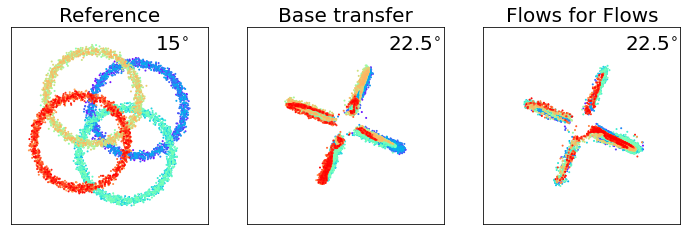

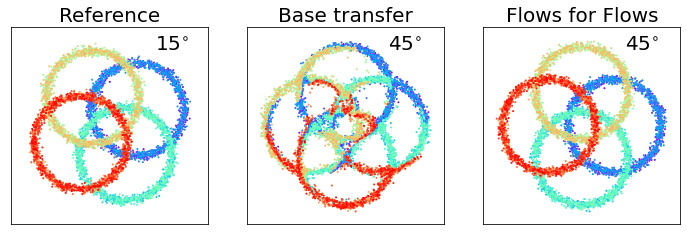

In [24]:
import matplotlib.cm as cm


def plot_color_coded_transfer_cond(all_results_dir, combo, base_key, target_key_1, target_key_2, code_l, code_r, size = 6, b = np.linspace(-3, 3, 100), 
                              cmap = cm.rainbow, n_points = 7000, s = 1):
    
    fig, ax = plt.subplots(1, 3, figsize = (2*size, size))
    
    # we only want to plot every n_th point
    num_total_points = len(all_results_dir[combo][code_l][base_key][0])
    n_skip = int(num_total_points/n_points)
    colors = [cmap(x) for x in np.linspace(0, 1, n_points)]

    
    # input
    ax[0].scatter(all_results_dir[combo][code_l][base_key][0][:n_skip*n_points:n_skip], all_results_dir[combo][code_l][base_key][1][:n_skip*n_points:n_skip], color=colors, s = s, rasterized = True)
    ax[0].set_title("Reference", fontsize = f_1)
    if code_l.split("_")[1] == "50":
        code_str = code_l.split("_")[0]+".5$^{\circ}$"
    else:
        code_str = code_l.split("_")[0]+"$^{\circ}$"
    ax[0].text(1.4, 2.3, code_str, fontsize = f_1)
    
    # target 1
    if code_r.split("_")[1] == "50":
        code_str = code_r.split("_")[0]+".5$^{\circ}$"
    else:
        code_str = code_r.split("_")[0]+"$^{\circ}$"
    ax[1].text(1.3, 2.3, code_str, fontsize = f_1)
    ax[2].text(1.3, 2.3, code_str, fontsize = f_1)
    
    ax[1].scatter(all_results_dir[combo][code_r][target_key_1][0][:n_skip*n_points:n_skip], all_results_dir[combo][code_r][target_key_1][1][:n_skip*n_points:n_skip], color=colors, s = s, rasterized = True)
    ax[1].set_title("Base transfer", fontsize = f_1)

    ax[2].scatter(all_results_dir[combo][code_r][target_key_2][0][:n_skip*n_points:n_skip], all_results_dir[combo][code_r][target_key_2][1][:n_skip*n_points:n_skip], color=colors, s = s, rasterized = True)
    ax[2].set_title("Flows for Flows", fontsize = f_1)

    
    
    # axis settings
    for i in range(3):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_xlim([-3, 3])
        ax[i].set_ylim([-3, 3])
        ax[i].set_aspect("equal")

    #plt.subplots_adjust(wspace=0, hspace=0)
    fig.show()
    plt.savefig(f"plots/{combo}_cond_{target_key_1}_{target_key_2}_{code_l}_{code_r}.pdf", bbox_inches="tight", dpi = dpi)
    
plot_color_coded_transfer_cond(results_transfer_cond, "fourcircles_star", "left", "base_transfer", "f4f", "15_00", "22_50")
plot_color_coded_transfer_cond(results_identity_cond, "fourcircles_fourcircles", "left", "base_transfer","f4f", "15_00", "45_00")


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  if __name__ == '__main__':
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap 

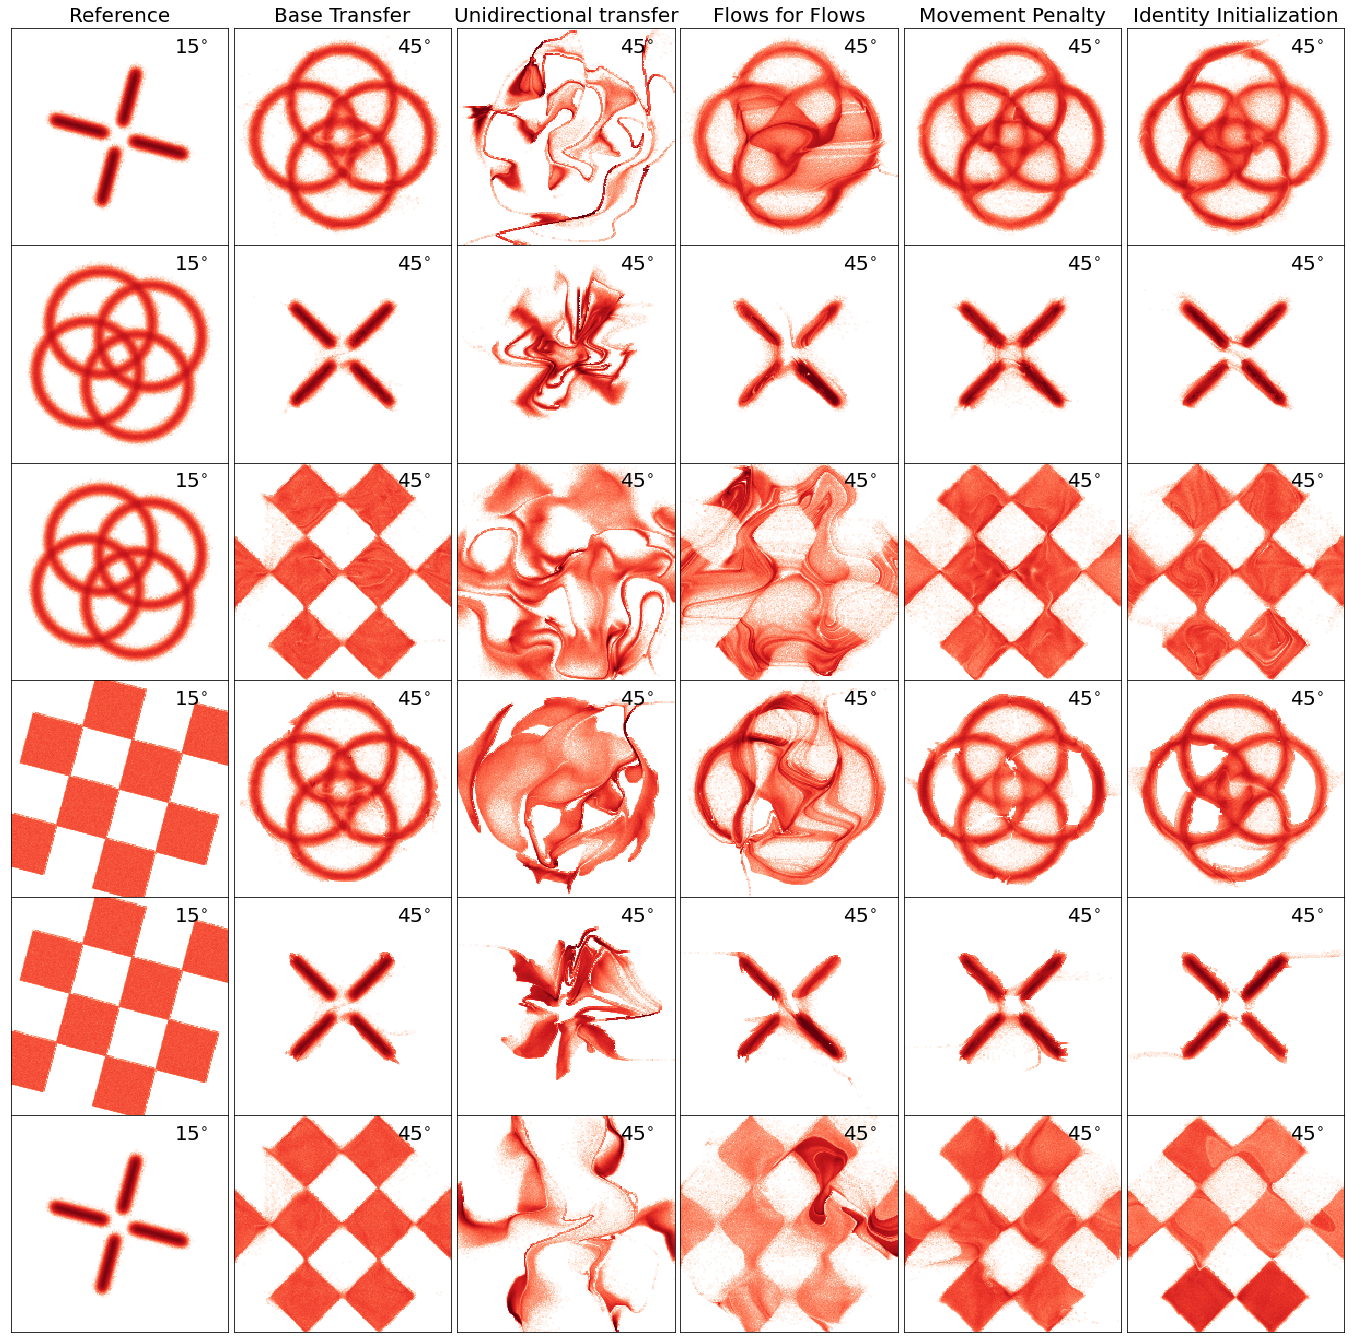

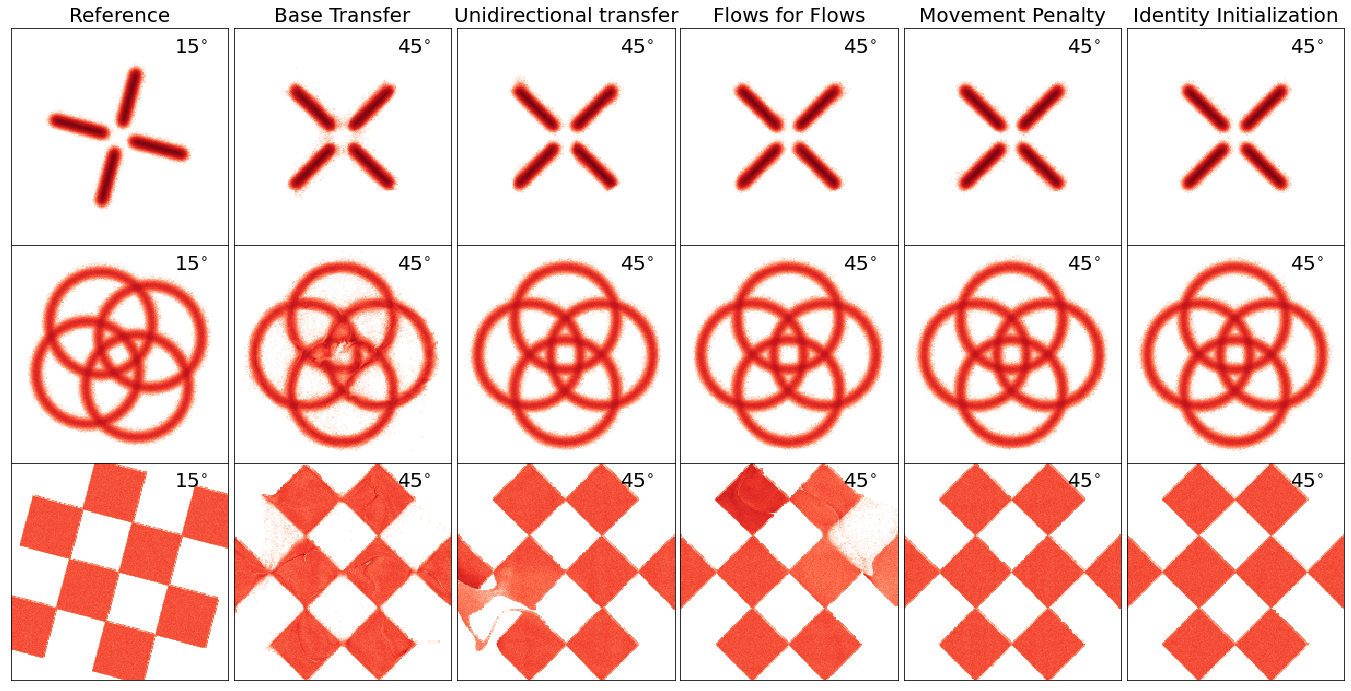

In [25]:
from matplotlib.colors import LogNorm




def plot_all_methods_1cond(keys_to_plot, combos_to_plot, all_results_dict, keyword, code_l, code_r, size = 4, b = 200, 
                              cmap = cm.Reds, l = 3):
    
    cmap.set_under("white")

    num_plots = len(keys_to_plot)
    num_combos = len(combos_to_plot)
    
    fig, ax = plt.subplots(num_combos, num_plots, figsize = (num_plots*size, num_combos*size))

    for j, combo in enumerate(combos_to_plot):
        
        for i, key in enumerate(keys_to_plot):
            
            if key == "left":
                code = code_l
            else: 
                code = code_r
                        
            lll = ax[j,i].hist2d(all_results_dict[combo][code][key][0], all_results_dict[combo][code][key][1], 
                           bins = np.linspace(-l, l, b), cmap = cmap, vmax = 1.4, norm=LogNorm(),
                                 density = True, rasterized = True)
            
            if j == 0:
                ax[j,i].set_title(labels_dir[key], fontsize = f_1)

            if code.split("_")[1] == "50":
                code_str = code.split("_")[0]+".5$^{\circ}$"
            else:
                code_str = code.split("_")[0]+"$^{\circ}$"
            ax[j,i].text(1.5, 2.3, code_str, fontsize = f_1)

            # axis settings
            ax[j,i].set_xticks([])
            ax[j,i].set_yticks([])
            ax[j,i].set_xlim([-l, l])
            ax[j,i].set_ylim([-l, l])
            ax[j,i].set_aspect("equal")

    plt.subplots_adjust(wspace=0, hspace=0)
    fig.show()
    plt.savefig(f"plots/summary_cond_{keyword}_{code_l}_{code_r}.pdf", bbox_inches="tight", dpi = dpi)


keys_to_plot = ["left", "base_transfer", "unidir_end", "f4f", "L1_end", "II_end"]
plot_all_methods_1cond(keys_to_plot, combos_transfer, results_transfer_cond, "transfer", "15_00", "45_00")
plot_all_methods_1cond(keys_to_plot, combos_identity, results_identity_cond,"identity", "15_00", "45_00")


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  import sys
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax d

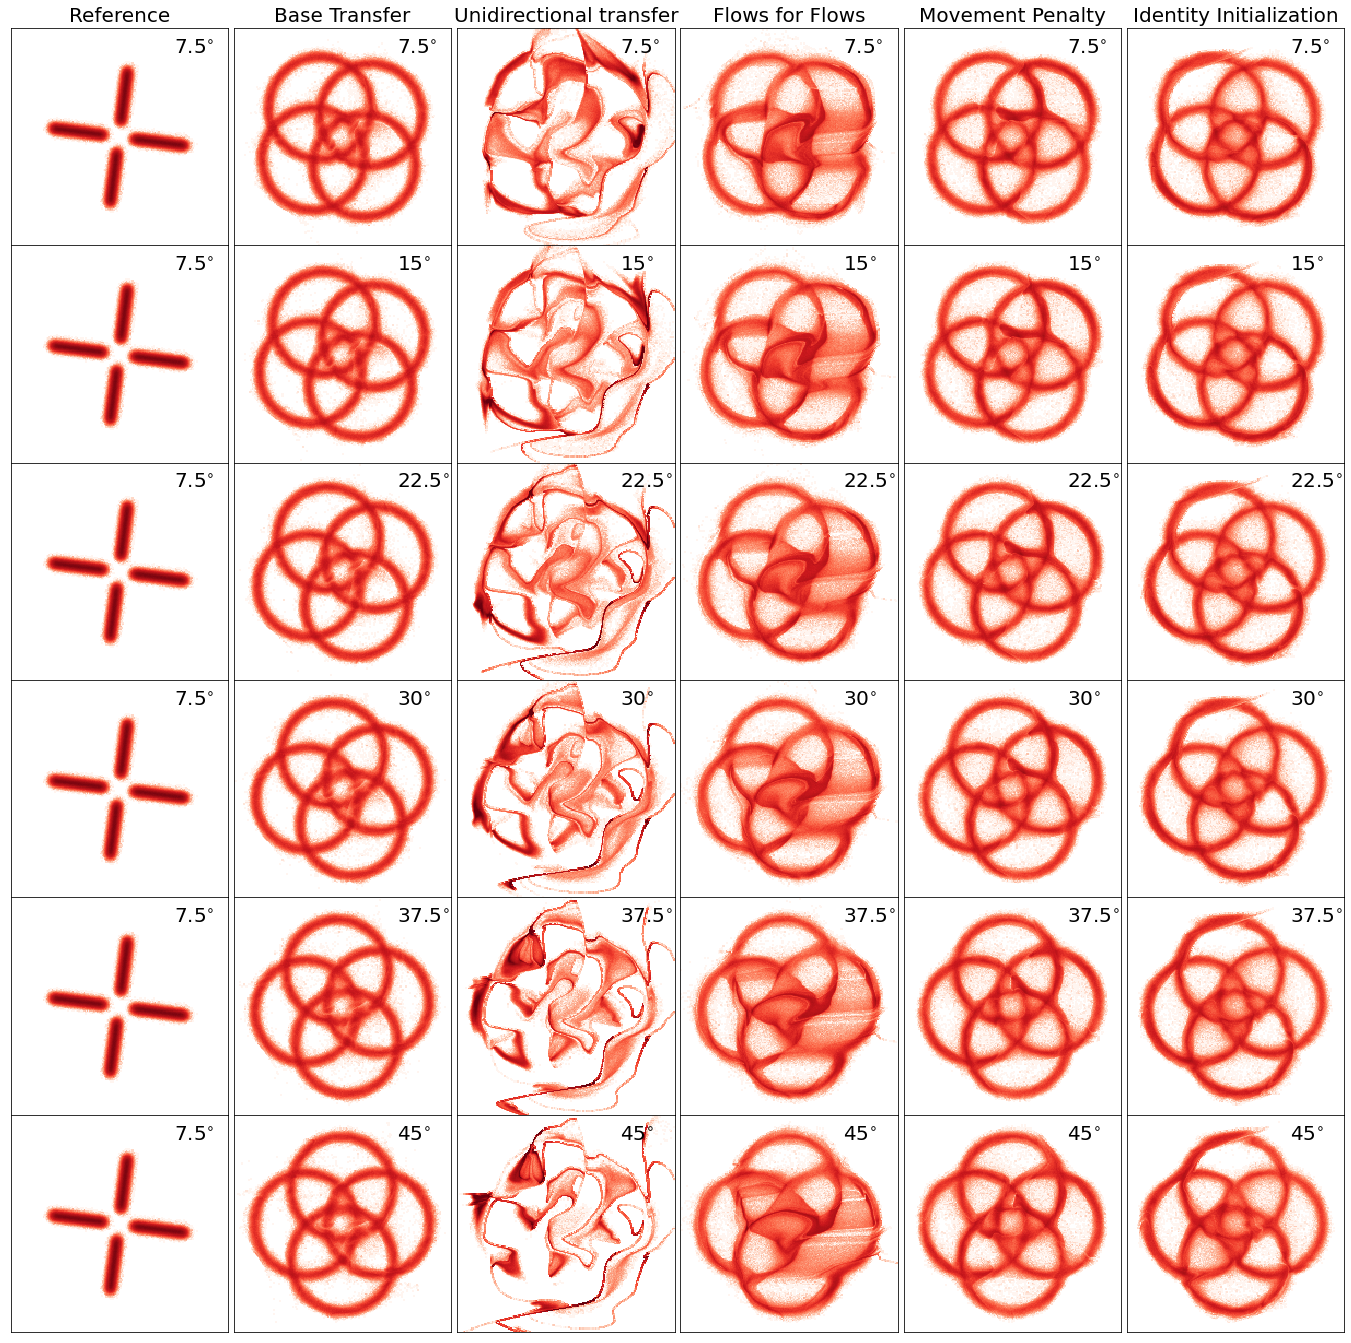

In [26]:
from matplotlib.colors import LogNorm


def plot_all_methods_allcond(keys_to_plot, codes_to_plot, all_results_dict, keyword, combo, size = 4, b = 200, 
                              cmap = cm.Reds, l = 3):
    
    cmap.set_under("white")

    num_plots = len(keys_to_plot)
    num_codes = len(codes_to_plot)
    
    fig, ax = plt.subplots(num_codes, num_plots, figsize = (num_plots*size, num_codes*size))

    for j, code in enumerate(codes):
        
        for i, key in enumerate(keys_to_plot):
            
            if key == "left":
  
                lll = ax[j,i].hist2d(all_results_dict[combo]["7_50"][key][0], all_results_dict[combo]["7_50"][key][1], 
                               bins = np.linspace(-l, l, b), cmap = cmap, vmax = 1.4, norm=LogNorm(),
                                     density = True, rasterized = True)
                ax[j,i].text(1.5, 2.3, "7.5$^{\circ}$", fontsize = f_1)
            else:
                lll = ax[j,i].hist2d(all_results_dict[combo][code][key][0], all_results_dict[combo][code][key][1], 
                               bins = np.linspace(-l, l, b), cmap = cmap, vmax = 1.4, norm=LogNorm(),
                                     density = True, rasterized = True)
                if code.split("_")[1] == "50":
                    code_str = code.split("_")[0]+".5$^{\circ}$"
                else:
                    code_str = code.split("_")[0]+"$^{\circ}$"
                
                ax[j,i].text(1.5, 2.3, code_str, fontsize = f_1)
            
            
            if j == 0:
                ax[j,i].set_title(labels_dir[key], fontsize = f_1)
                
            

            # axis settings
            ax[j,i].set_xticks([])
            ax[j,i].set_yticks([])
            ax[j,i].set_xlim([-l, l])
            ax[j,i].set_ylim([-l, l])
            ax[j,i].set_aspect("equal")

    plt.subplots_adjust(wspace=0, hspace=0)
    fig.show()
    plt.savefig(f"plots/summary_cond_{keyword}.pdf", bbox_inches="tight", dpi = dpi)


keys_to_plot = ["left", "base_transfer", "unidir_end", "f4f", "L1_end", "II_end"]
plot_all_methods_allcond(keys_to_plot, codes, results_transfer_cond, "transfer", "star_fourcircles")

#plot_all_methods_allcond(keys_to_plot, codes, results_identity_cond, "identity", "fourcircles_fourcircles")
